Import Modules

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import decode_data as dd
import seaborn as sns

In [2]:
## Get Data
[bytes,transactions,transaction_time,cell_register_reads,pec,local_pec,pec_ok,cell_v,cell_times] = dd.get_decoded_data(flip_bit=True)

Decoding...
7.19 %
14.38 %
21.58 %
28.77 %
35.96 %
43.15 %
50.35 %
57.54 %
64.73 %
71.92 %
79.12 %
86.31 %
93.50 %
100.0 %

Bad edges:  39


c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\decode_data.py:161: RuntimeWarning: overflow encountered in scalar multiply
  local_pec.append(np.array(remainder * 2).astype(np.uint16))


Total 3681 successful PEC checks -- 13.109 %


In [3]:
## Mean Measure Method
kNumCells = 12
kNumRetries = 3
kResampleSize = 2340

Xtransmitted = np.swapaxes(cell_v.reshape((kResampleSize,kNumRetries,kNumCells)), 0, 1)

Xbar = np.mean(Xtransmitted, axis=0)

Xdiff = np.abs(Xtransmitted - np.array([Xbar,Xbar,Xbar]))

## Generate results
Xgood_flag = Xdiff <= 11648
Xgood = np.multiply(Xtransmitted, Xgood_flag)

Xans = np.divide(np.sum(Xgood, axis=0), np.sum(Xgood_flag, axis=0))


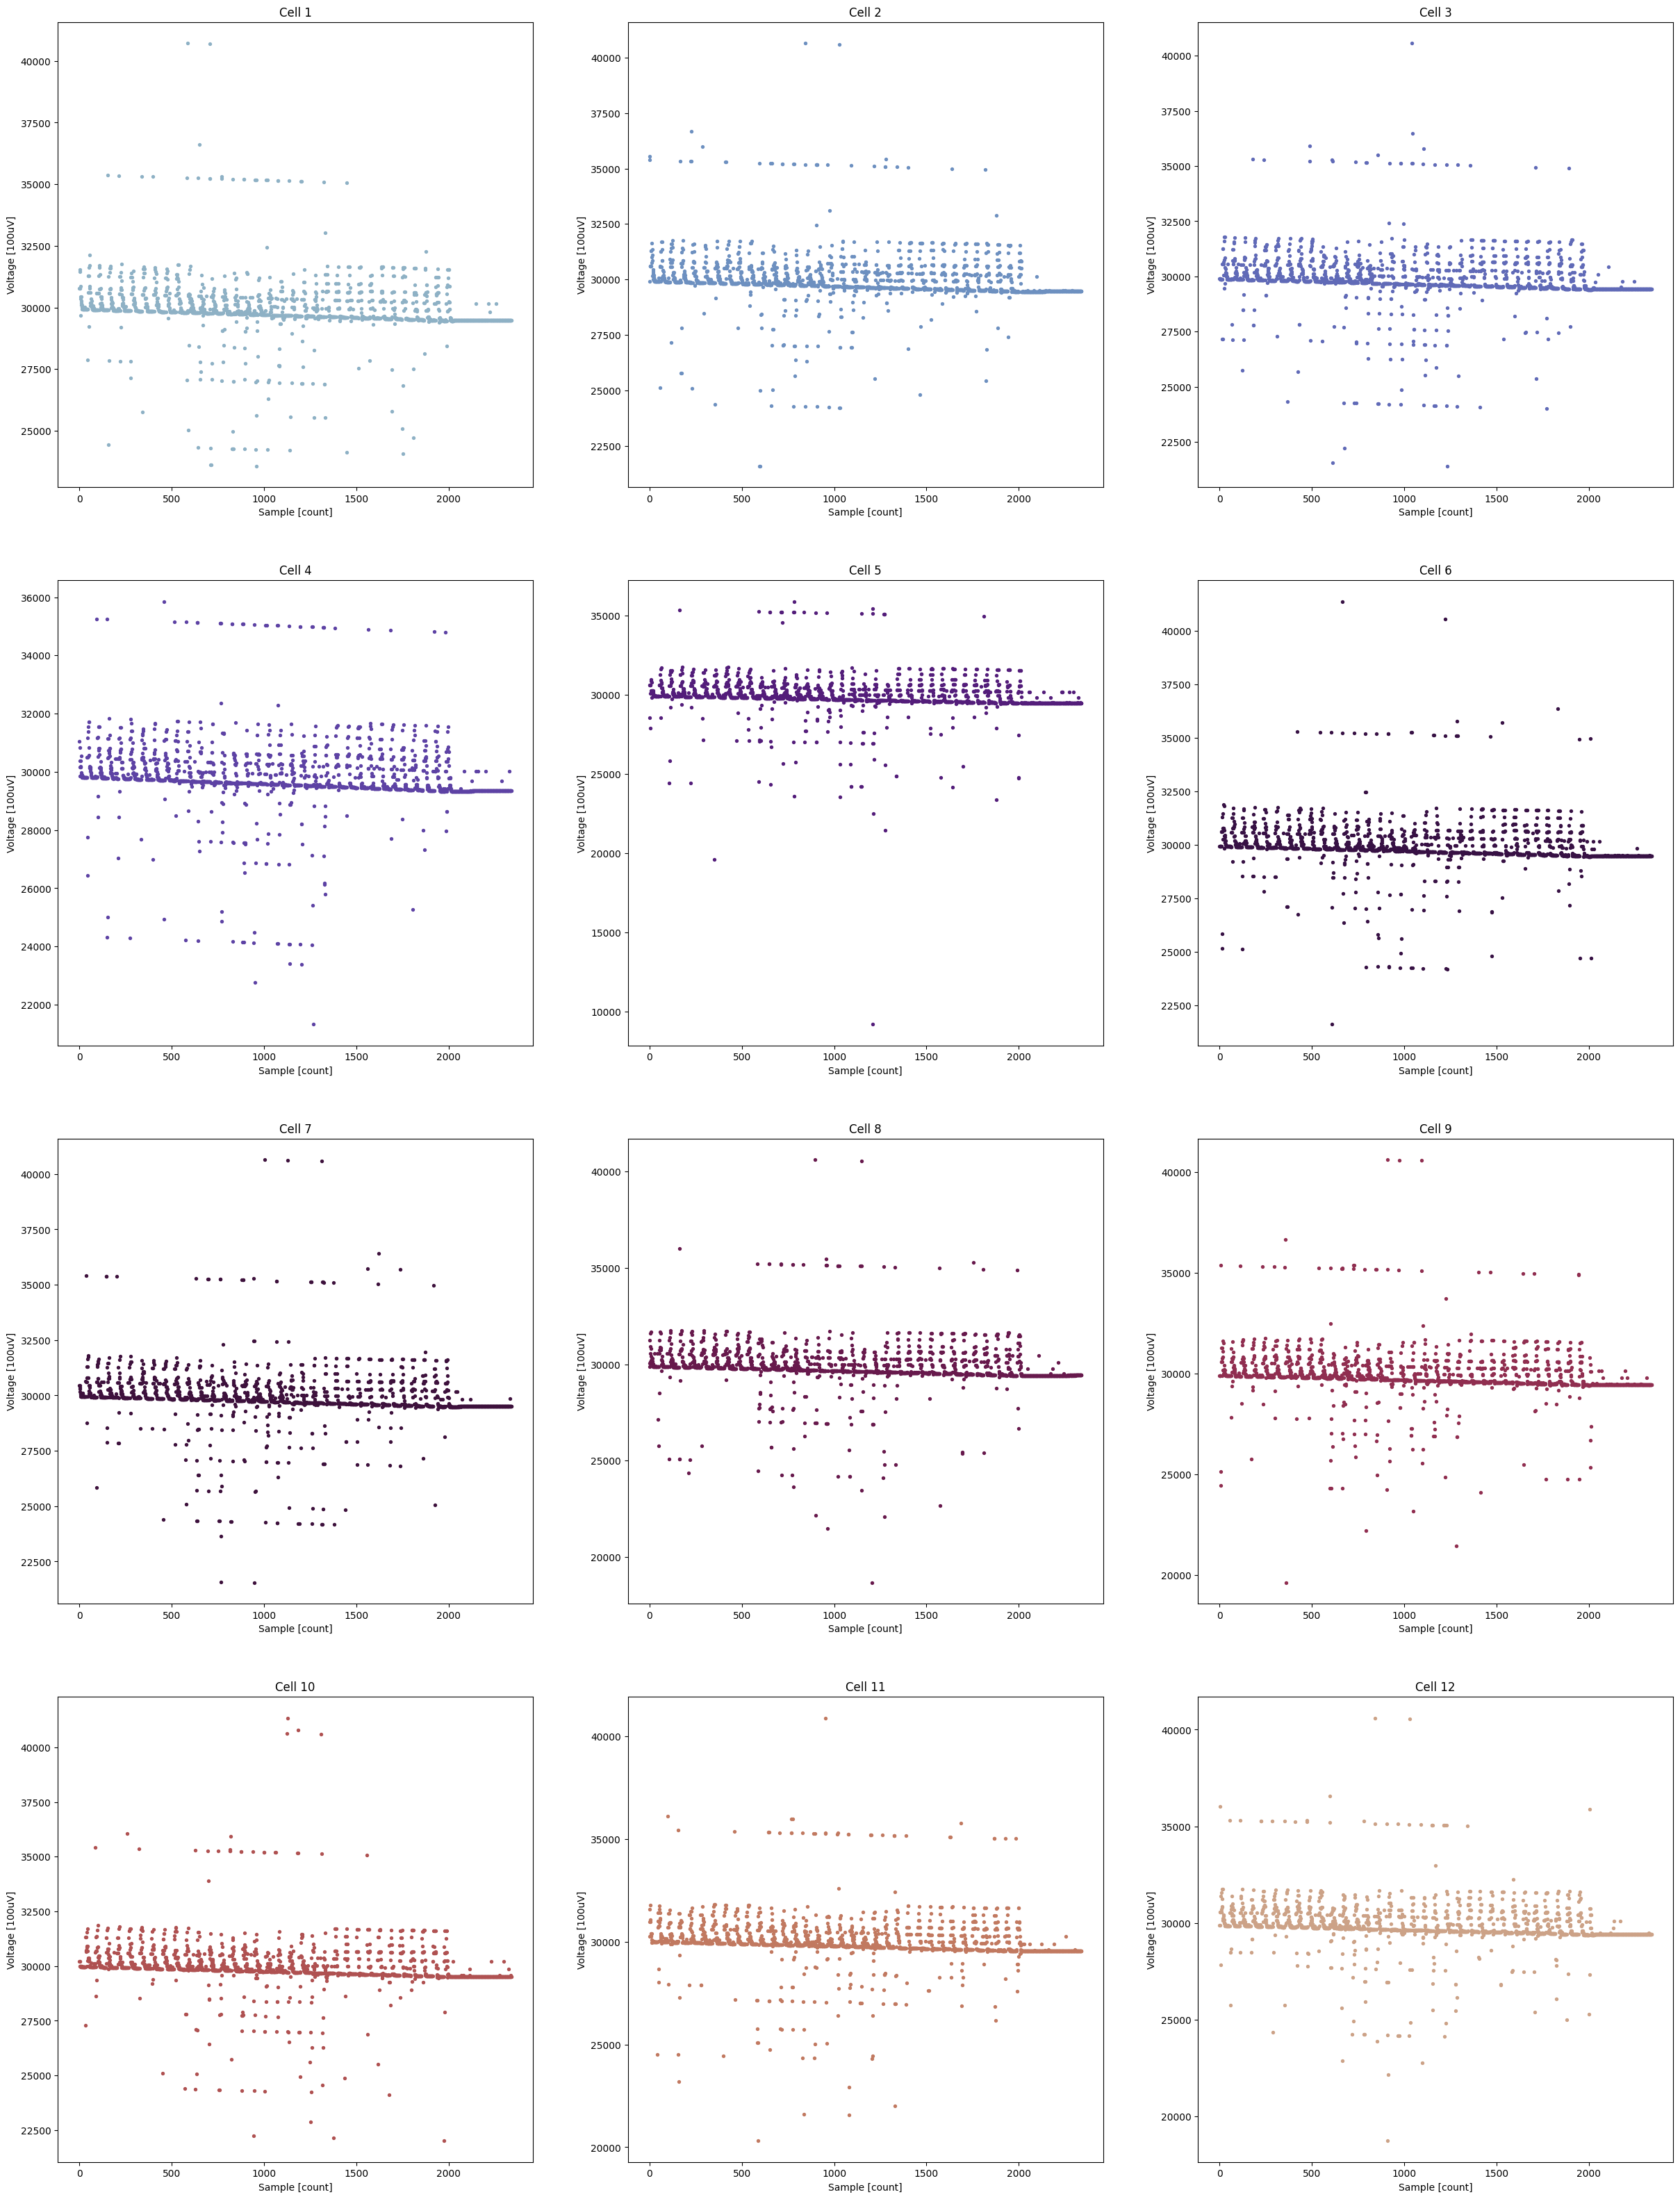

In [4]:
## Plot of Processed Data
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))

t = np.arange(0, Xans.shape[0])


for i in range(0, kNumCells):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, Xans[:,i], s=8, color=c[i+2])
    plot.set_xlabel("Sample [count]")
    plot.set_ylabel("Voltage [100uV]")
    name = "Cell " + str(i+1)
    plot.set_title(name)

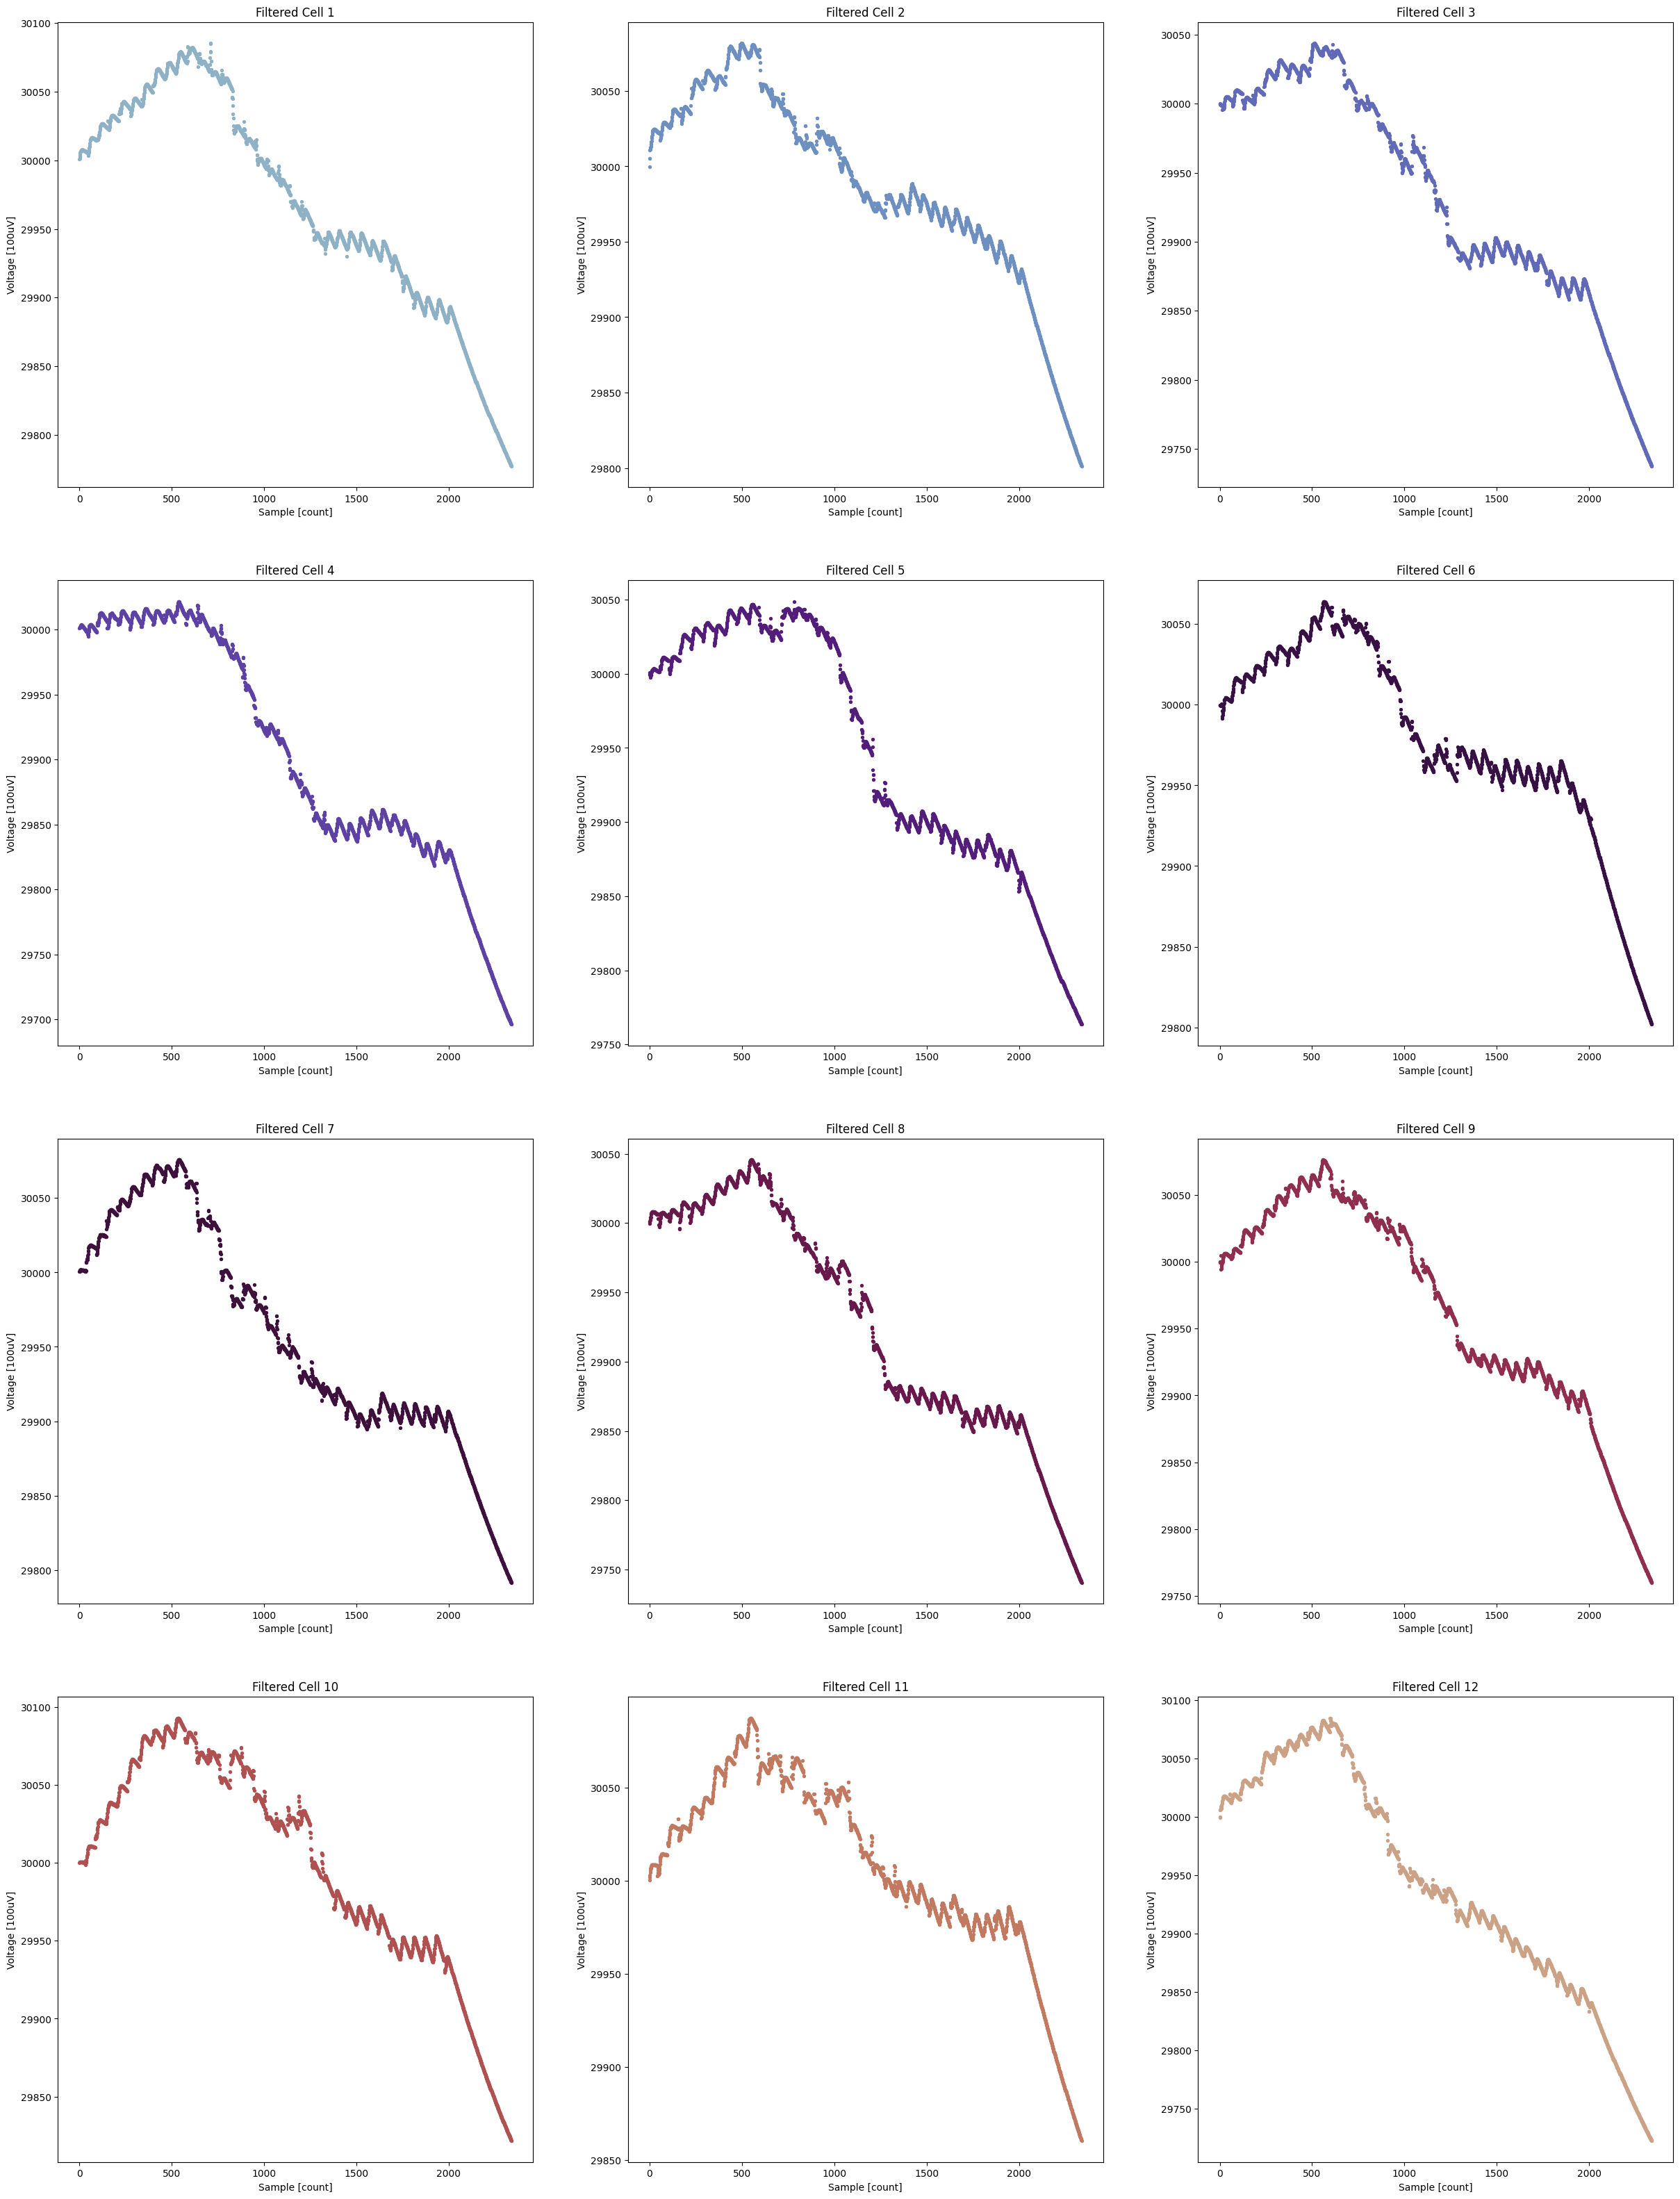

In [5]:
## Apply time filter
init_value = np.ones(12)*30000
Xfiltered = np.zeros(Xans.shape)
lam = 0.001

Xfiltered[0,:] = lam*Xans[0,:] + (1-lam)*init_value

for i in range(1, Xans.shape[0]):
    Xfiltered[i,:] = lam*Xans[i] + (1-lam)*Xfiltered[i-1,:]

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))
t = np.arange(0, Xfiltered.shape[0])
for i in range(0, kNumCells):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, Xfiltered[:,i], s=8, color=c[i+2])
    plot.set_xlabel("Sample [count]")
    plot.set_ylabel("Voltage [100uV]")
    name = "Filtered Cell " + str(i+1)
    plot.set_title(name)

In [42]:
## Bit Polling Method
Vcells = np.array([cell_v, cell_v, cell_v])
Vfliped_cells = np.zeros(Vcells.shape, dtype=np.uint16)
Vans = np.zeros(cell_v.shape, dtype=np.uint16)

kNumBits = 16

# Add noise
use_seed = True

if use_seed:
    rng = np.random.default_rng(seed = 42)
else:
    rng = np.random.default_rng(12345)

bit_flip_location = rng.integers(low = 0, high = 16, size=Vcells.shape)
bit_flip_value = rng.integers(low = 0, high = 2, size=Vcells.shape)

# Generate matrix with additional bit flips
for i in range(0, Vcells.shape[2]):
    for j in range(0, Vcells.shape[0]):
        for k in range(0, Vcells.shape[1]):
            Vfliped_cells[j,k,i] = Vcells[j,k,i] ^ (bit_flip_value[j,k,i] << bit_flip_location[j,k,i])

# Poll each bit
for i in range(0, Vfliped_cells.shape[2]):
    for j in range(0, Vfliped_cells.shape[1]):
        
        # pre-emptively flip msb if cell value is too high
        for k in range(0, Vfliped_cells.shape[0]):
            if Vfliped_cells[k,j,i] > 45000 and ((Vfliped_cells[k,j,i] >> 15) == 0b1):
                Vfliped_cells[k,j,i] ^= (0b1 << 15)

        for b in range(0, kNumBits):
            b0 = ((Vfliped_cells[0,j,i] >> b) & 0b1)
            b1 = ((Vfliped_cells[1,j,i] >> b) & 0b1)
            b2 = ((Vfliped_cells[2,j,i] >> b) & 0b1)

            if((b0 == b1) or (b0 == b2)):
                Vans[j,i] |= (b0 << b)
            elif (b1 == b2):
                Vans[j,i] |= (b1 << b)
            else:
                Vans[j,i] = 0
                break

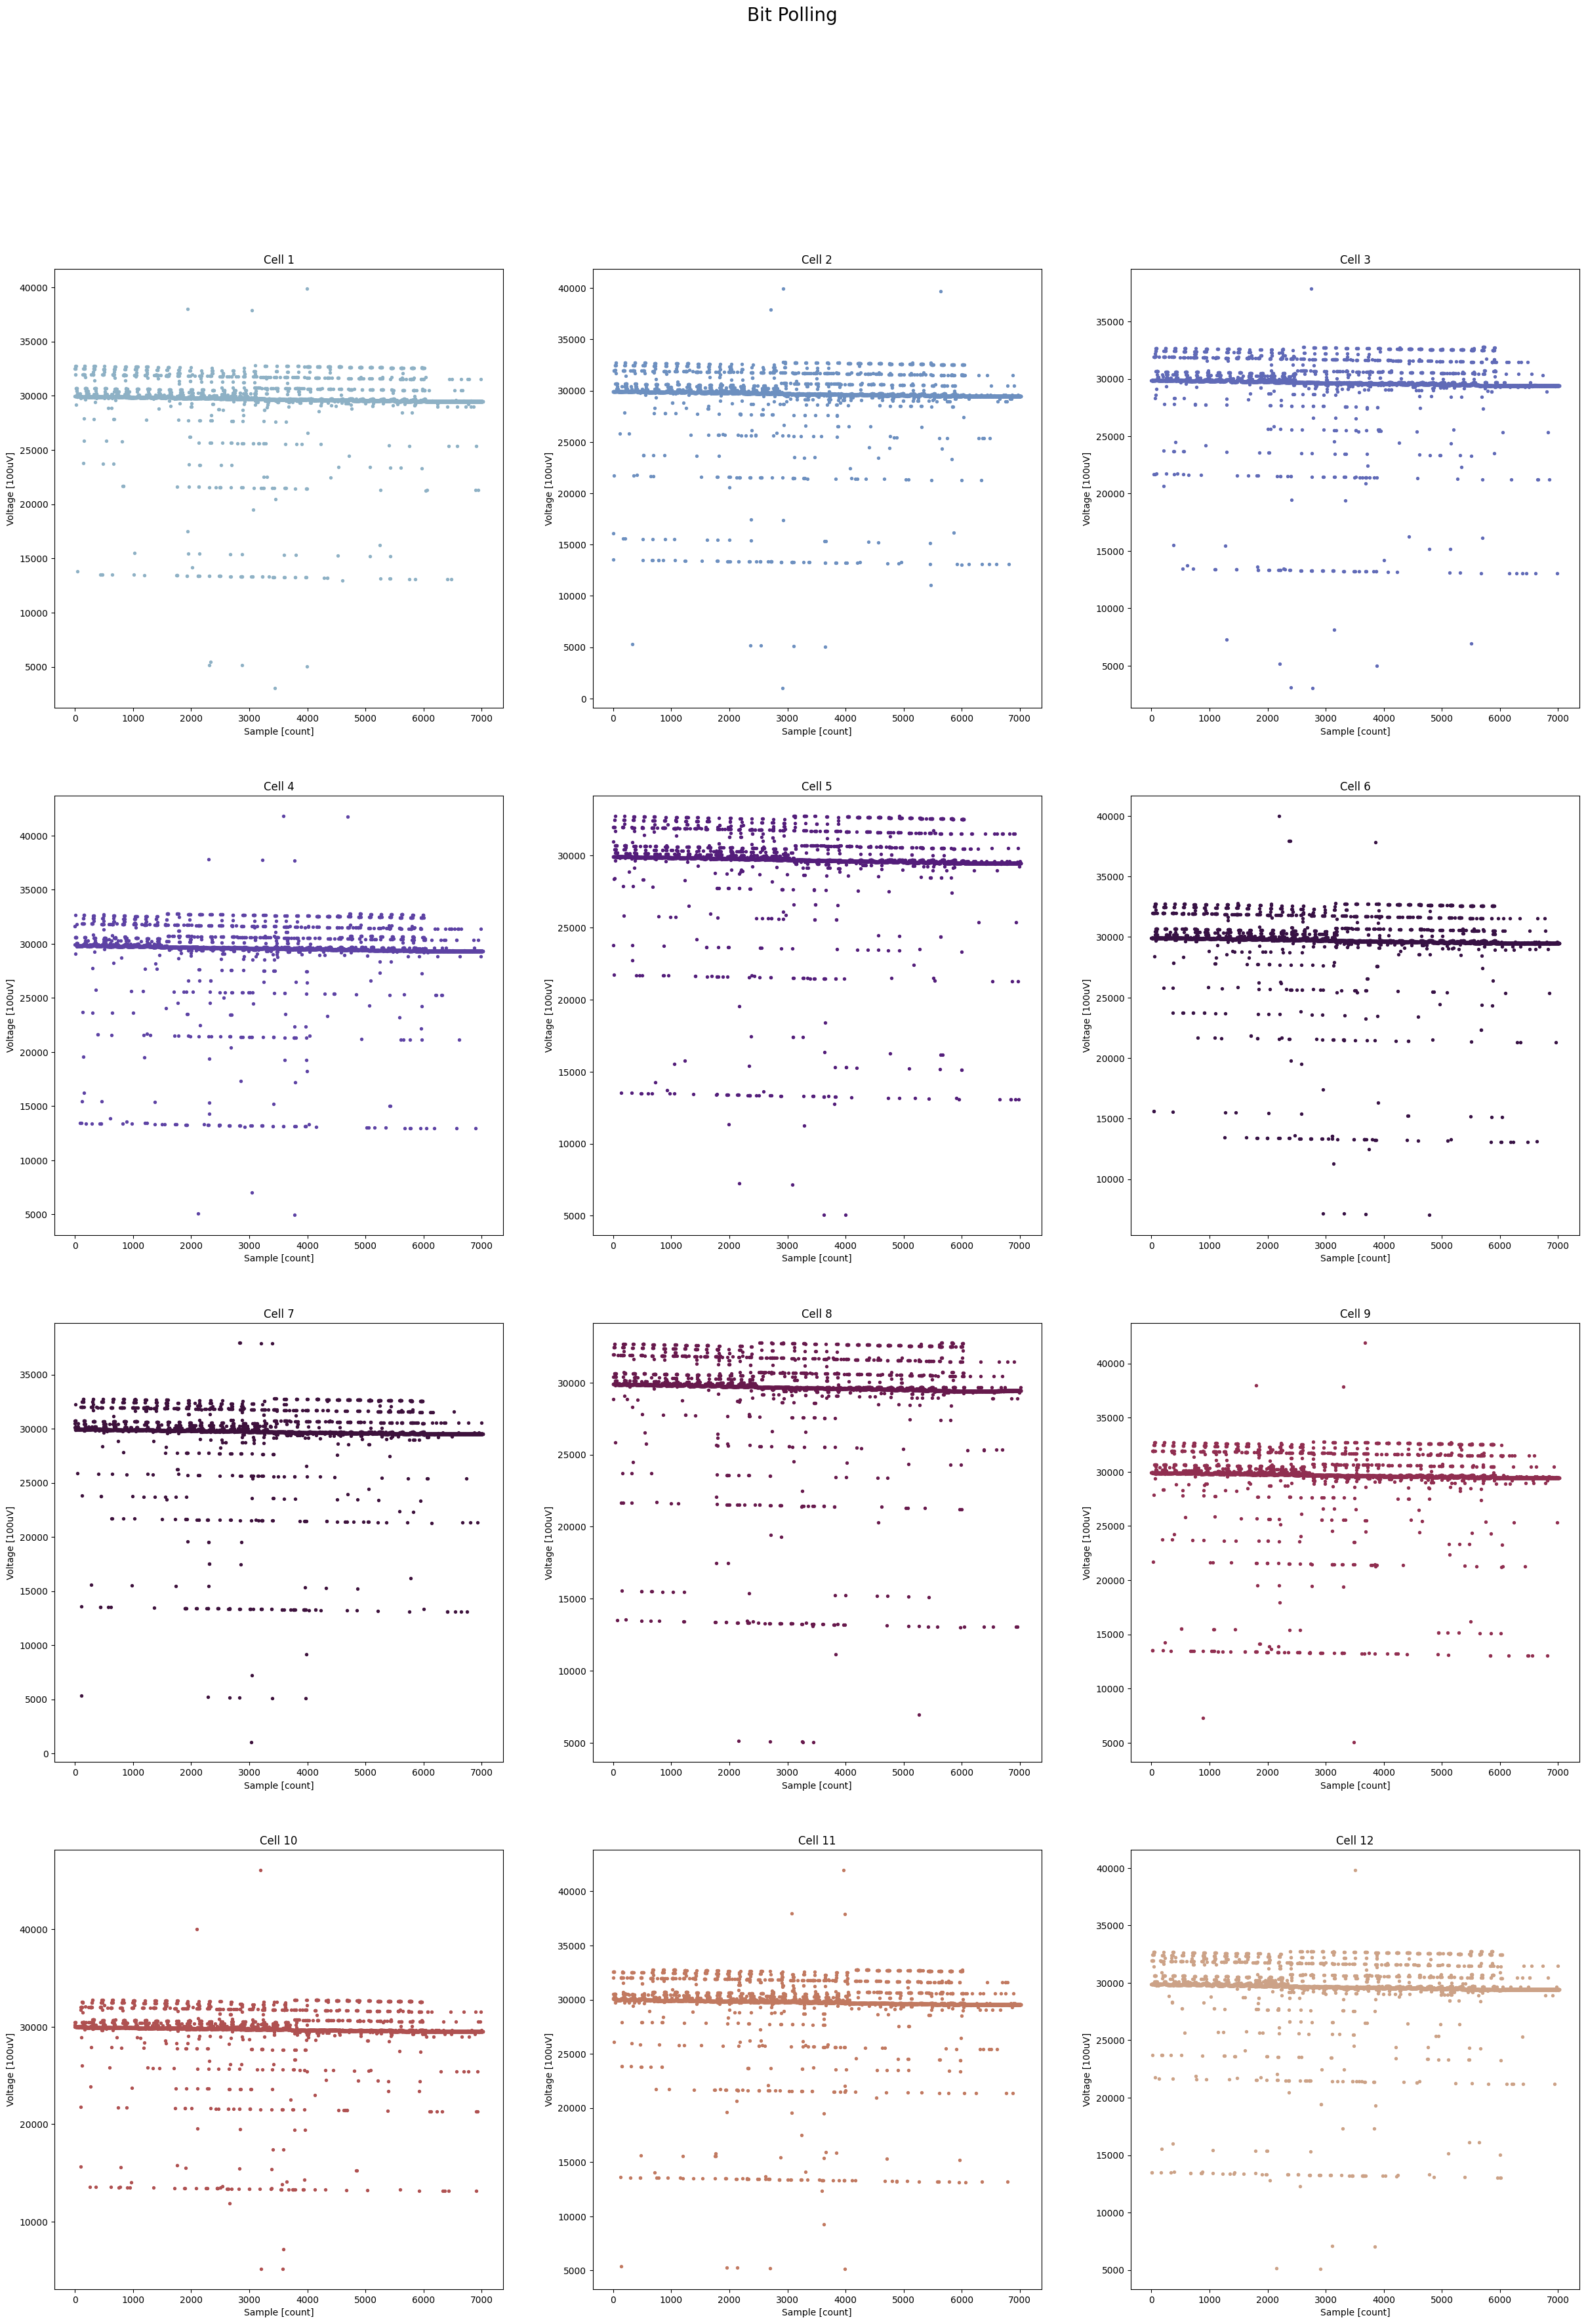

In [43]:
## Plots of processed data

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
fig.suptitle("Bit Polling", fontsize=20)
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))
t = np.arange(0, Vans.shape[0])
for i in range(0, kNumCells):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, Vans[:,i], s=8, color=c[i+2])
    plot.set_xlabel("Sample [count]")
    plot.set_ylabel("Voltage [100uV]")
    # plot.set_ylim([28000, 31000])
    name = "Cell " + str(i+1)
    plot.set_title(name)

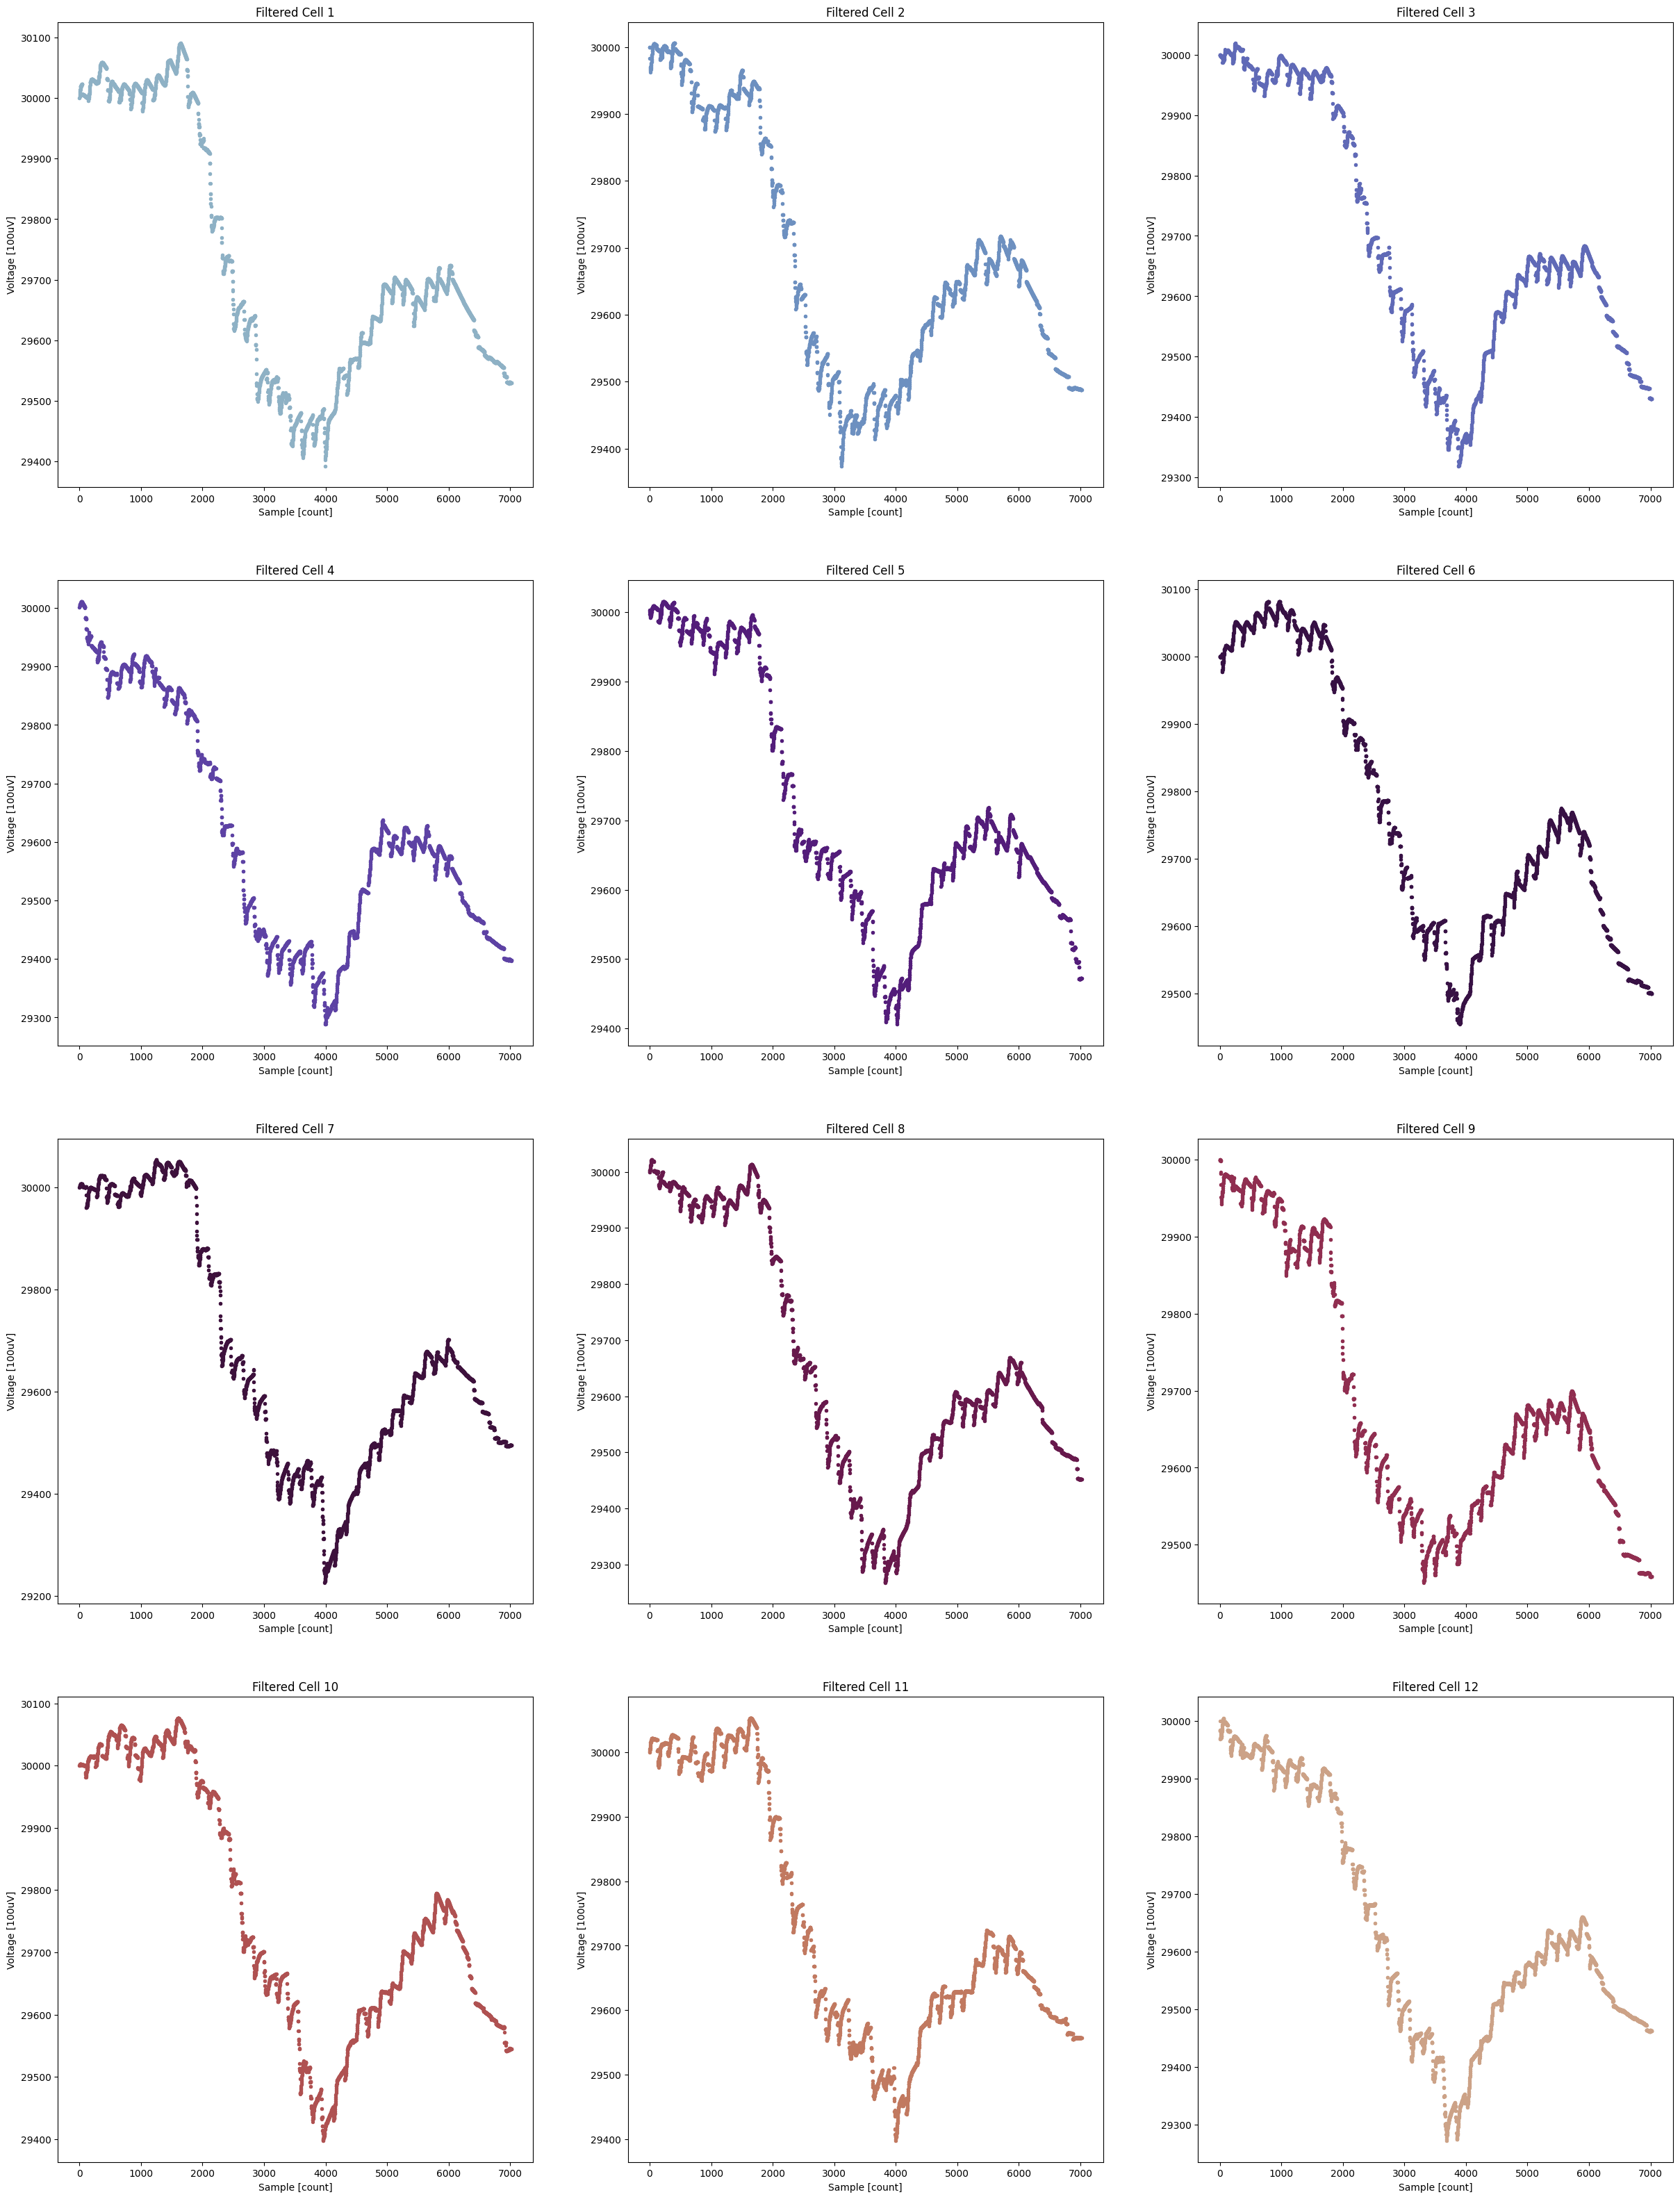

In [44]:
## Apply time filter
init_value = np.ones(12)*30000
Vfiltered = np.zeros(Vans.shape)
lam = 0.001

Vfiltered[0,:] = lam*Vans[0,:] + (1-lam)*init_value

for i in range(1, Vans.shape[0]):
    Vfiltered[i,:] = lam*Vans[i] + (1-lam)*Vfiltered[i-1,:]

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))
t = np.arange(0, Vfiltered.shape[0])
for i in range(0, kNumCells):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, Vfiltered[:,i], s=8, color=c[i+2])
    plot.set_xlabel("Sample [count]")
    plot.set_ylabel("Voltage [100uV]")
    name = "Filtered Cell " + str(i+1)
    plot.set_title(name)

<Axes: title={'center': 'Bit Polling'}>

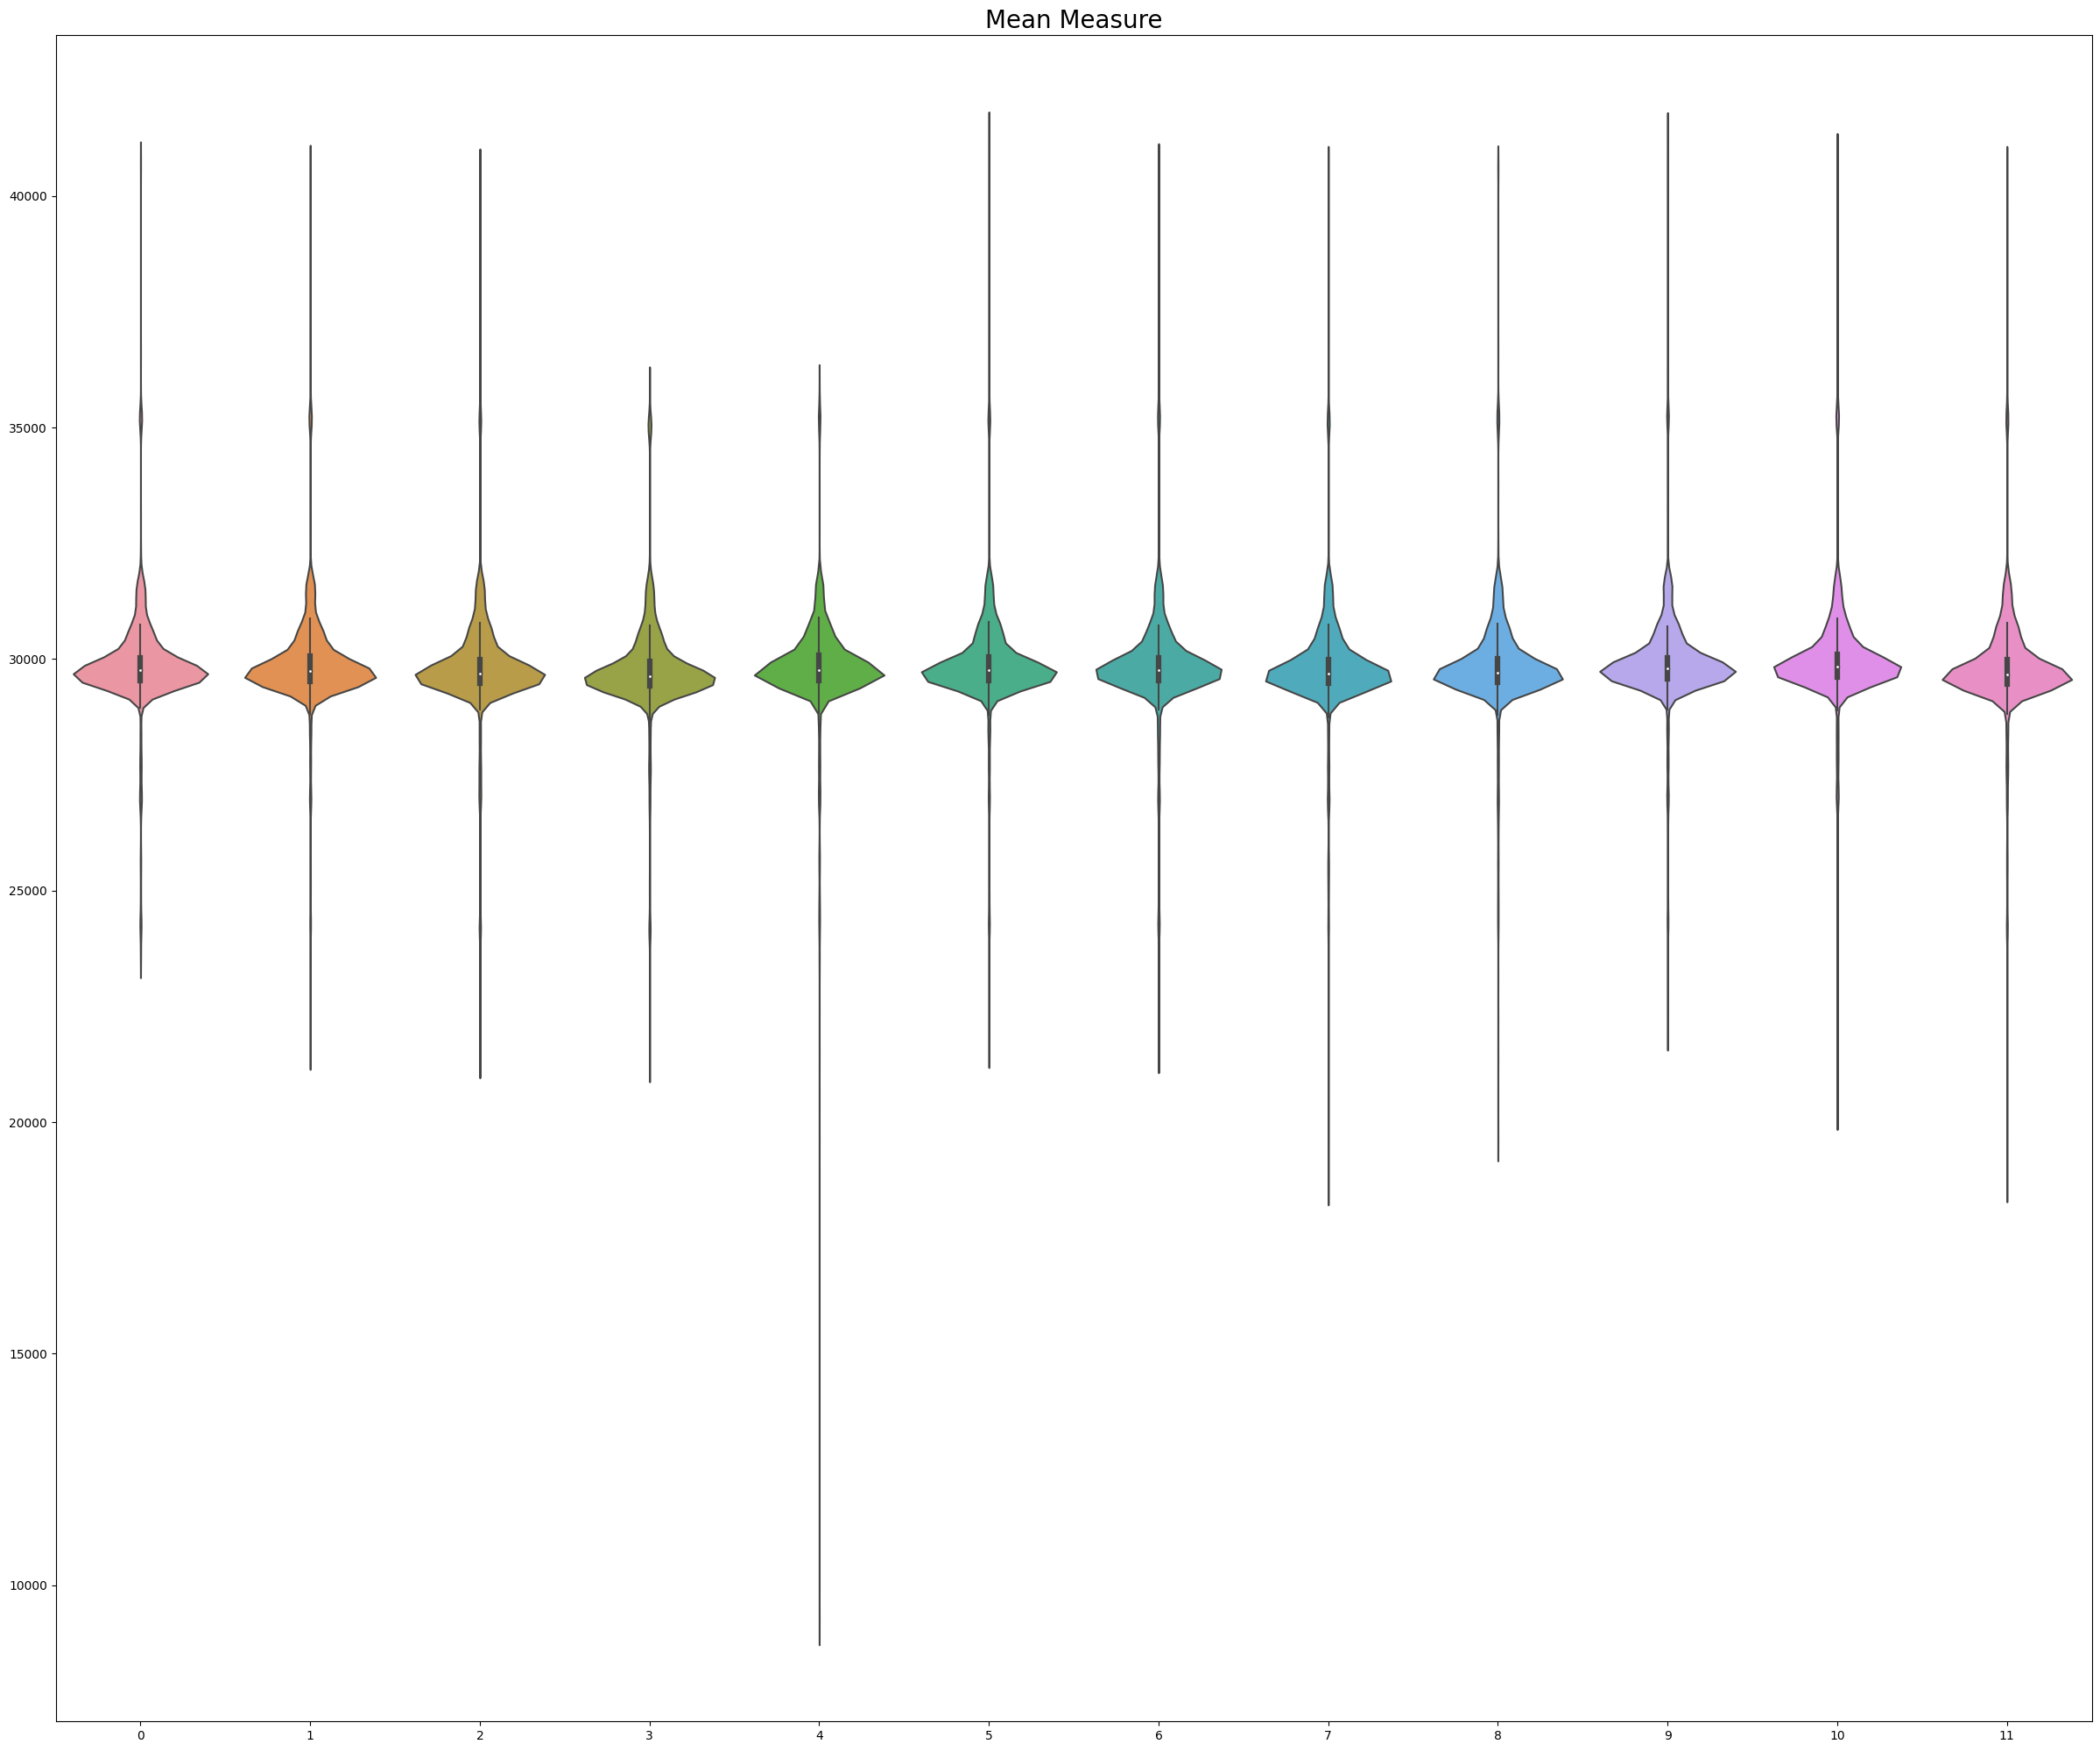

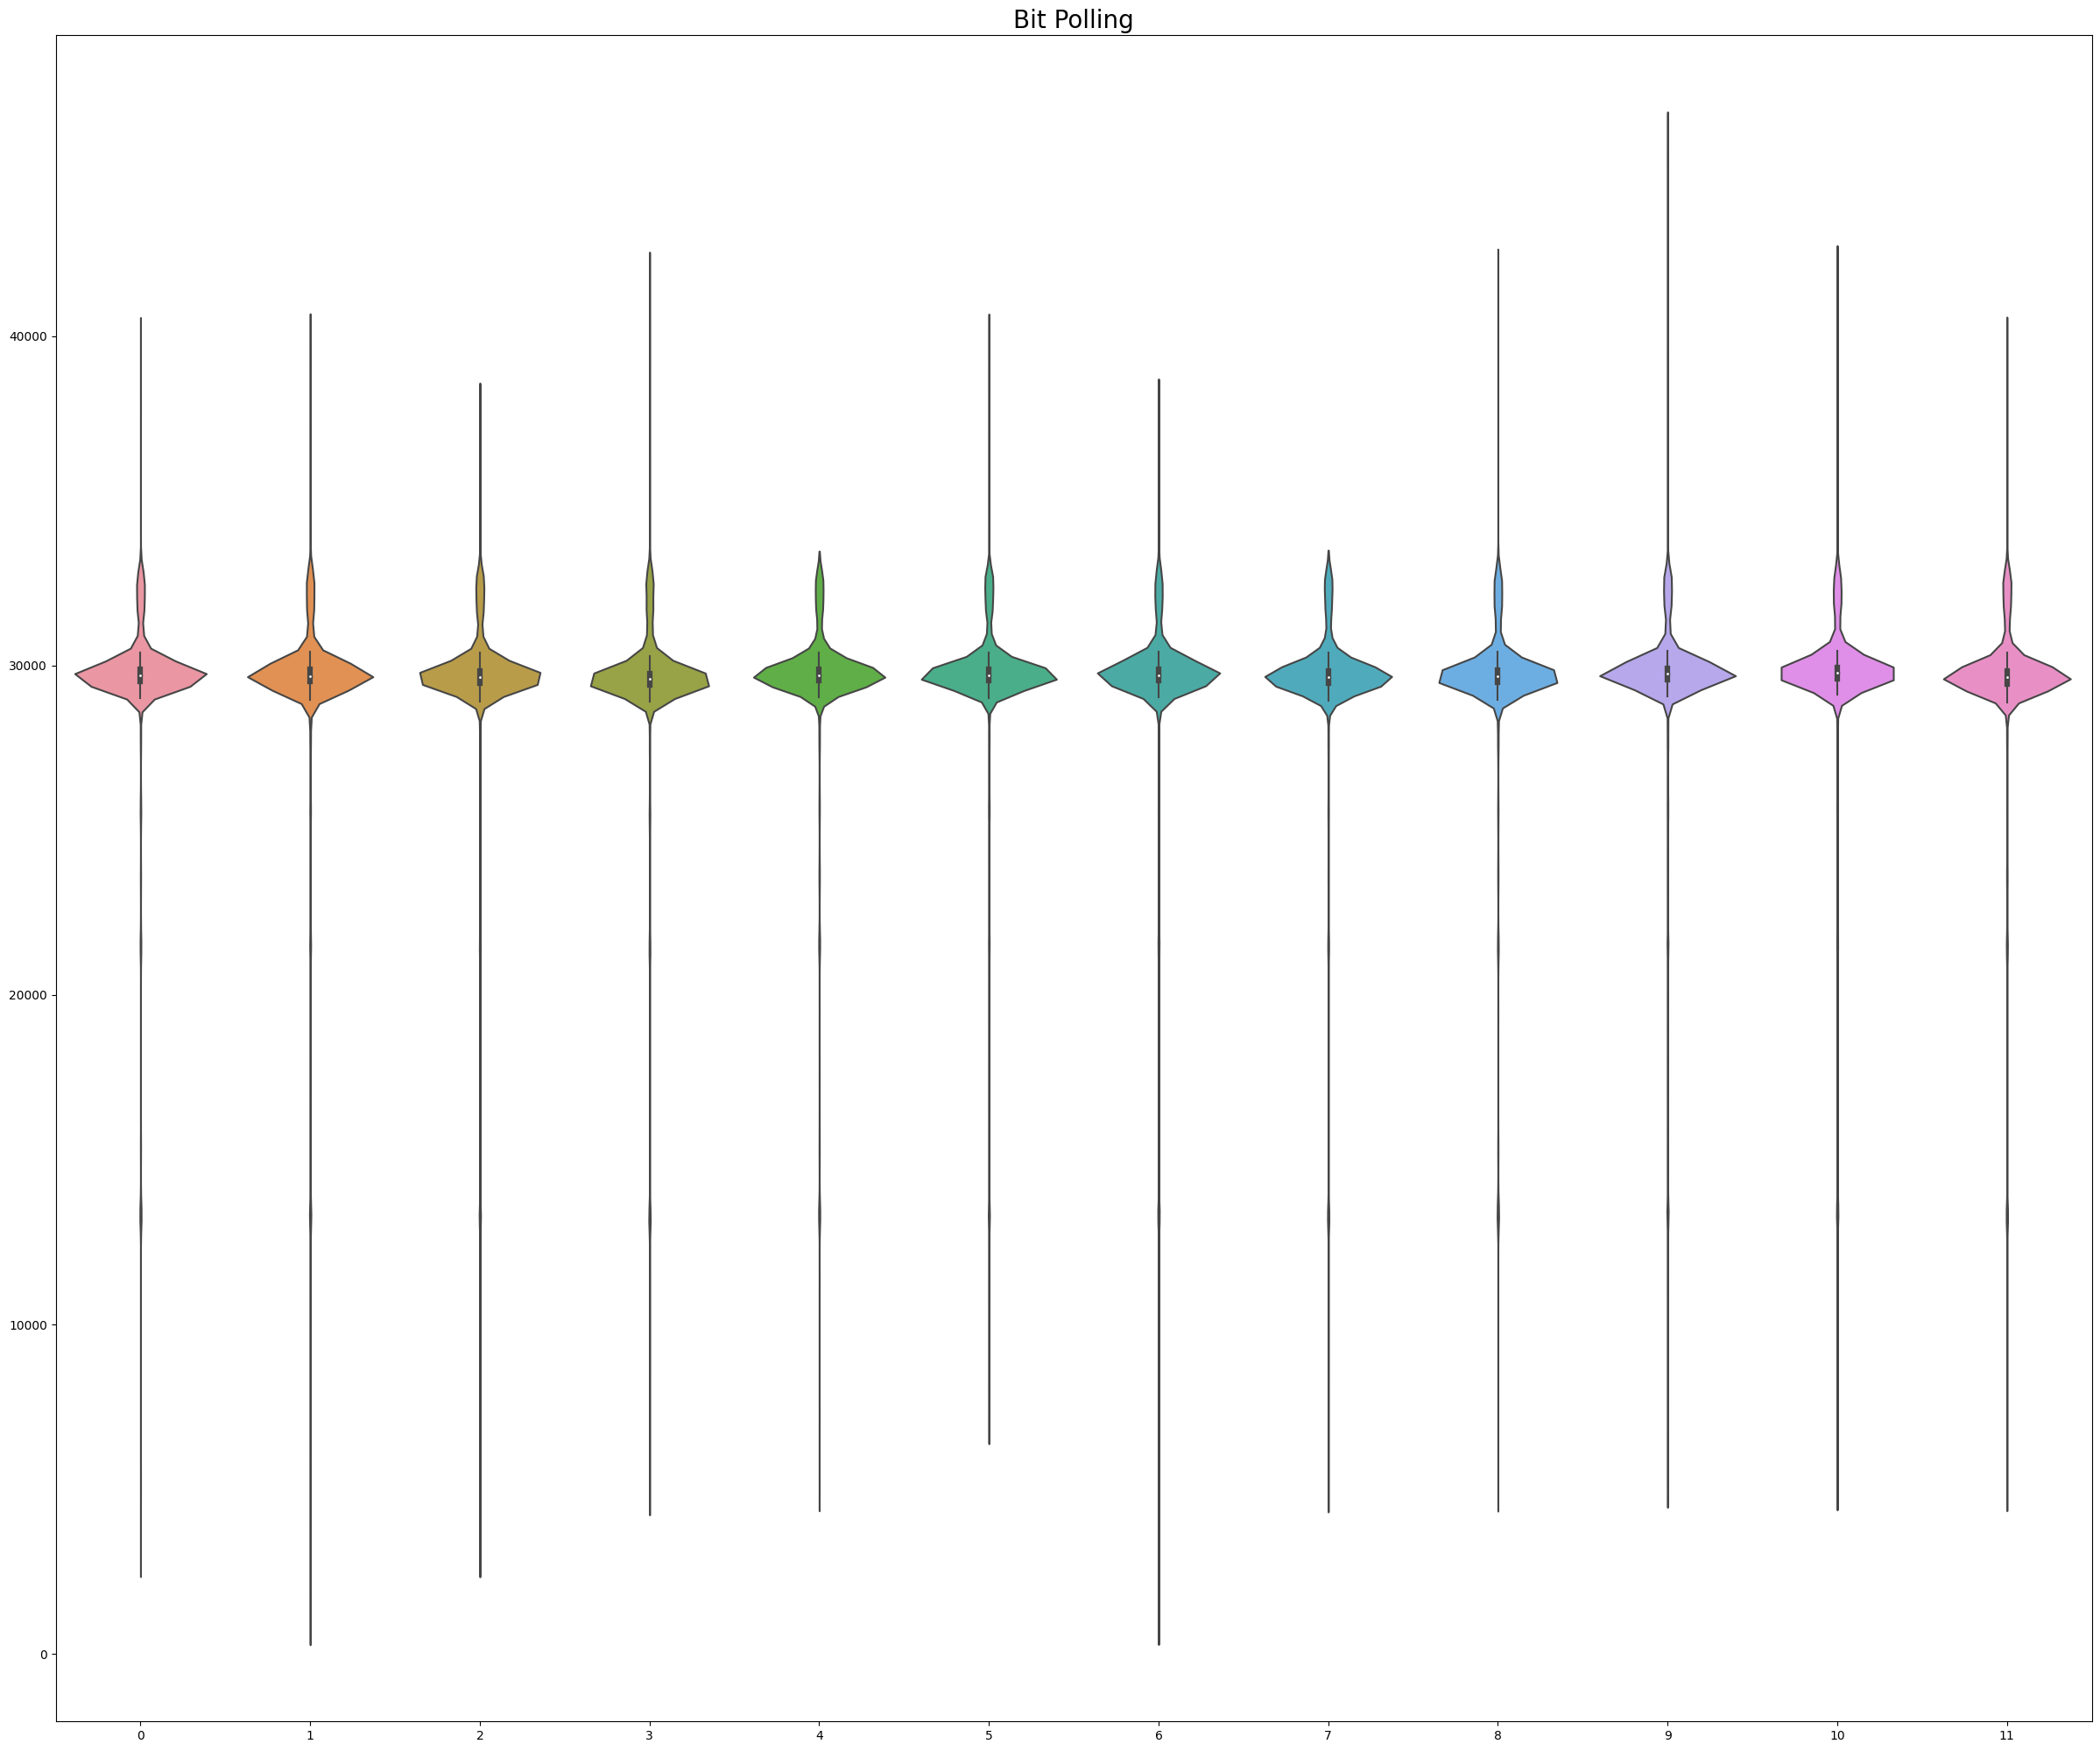

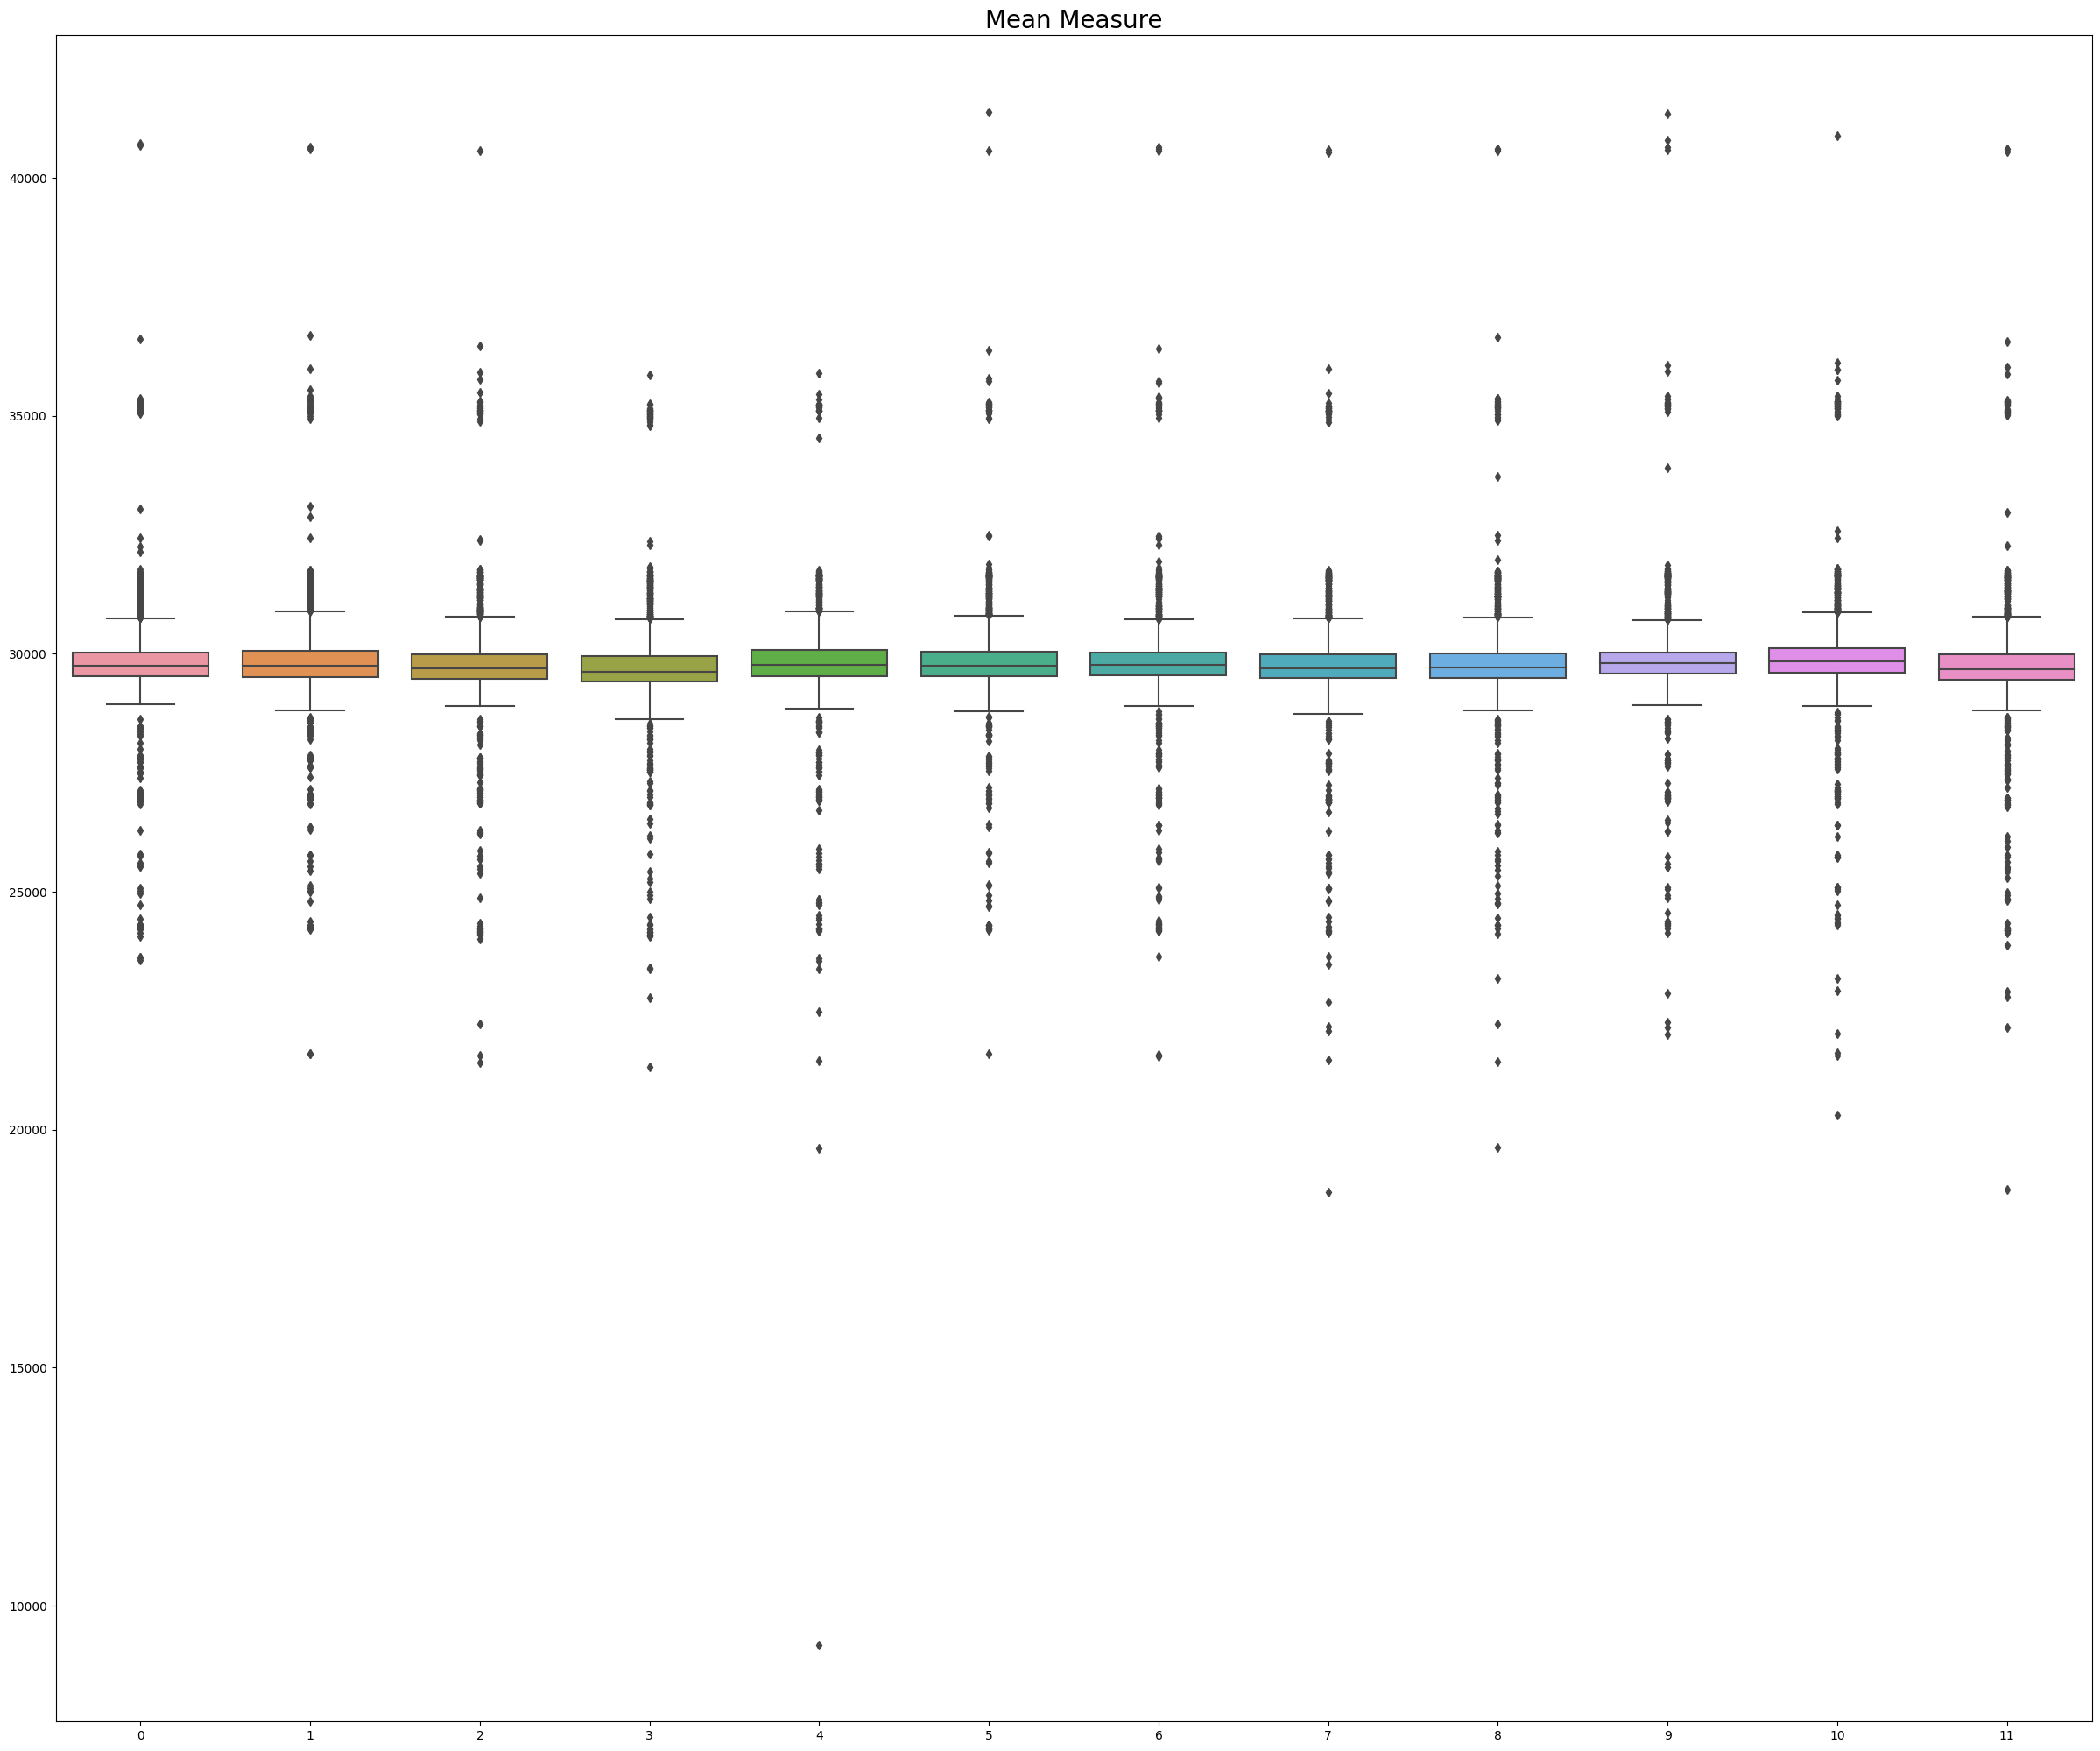

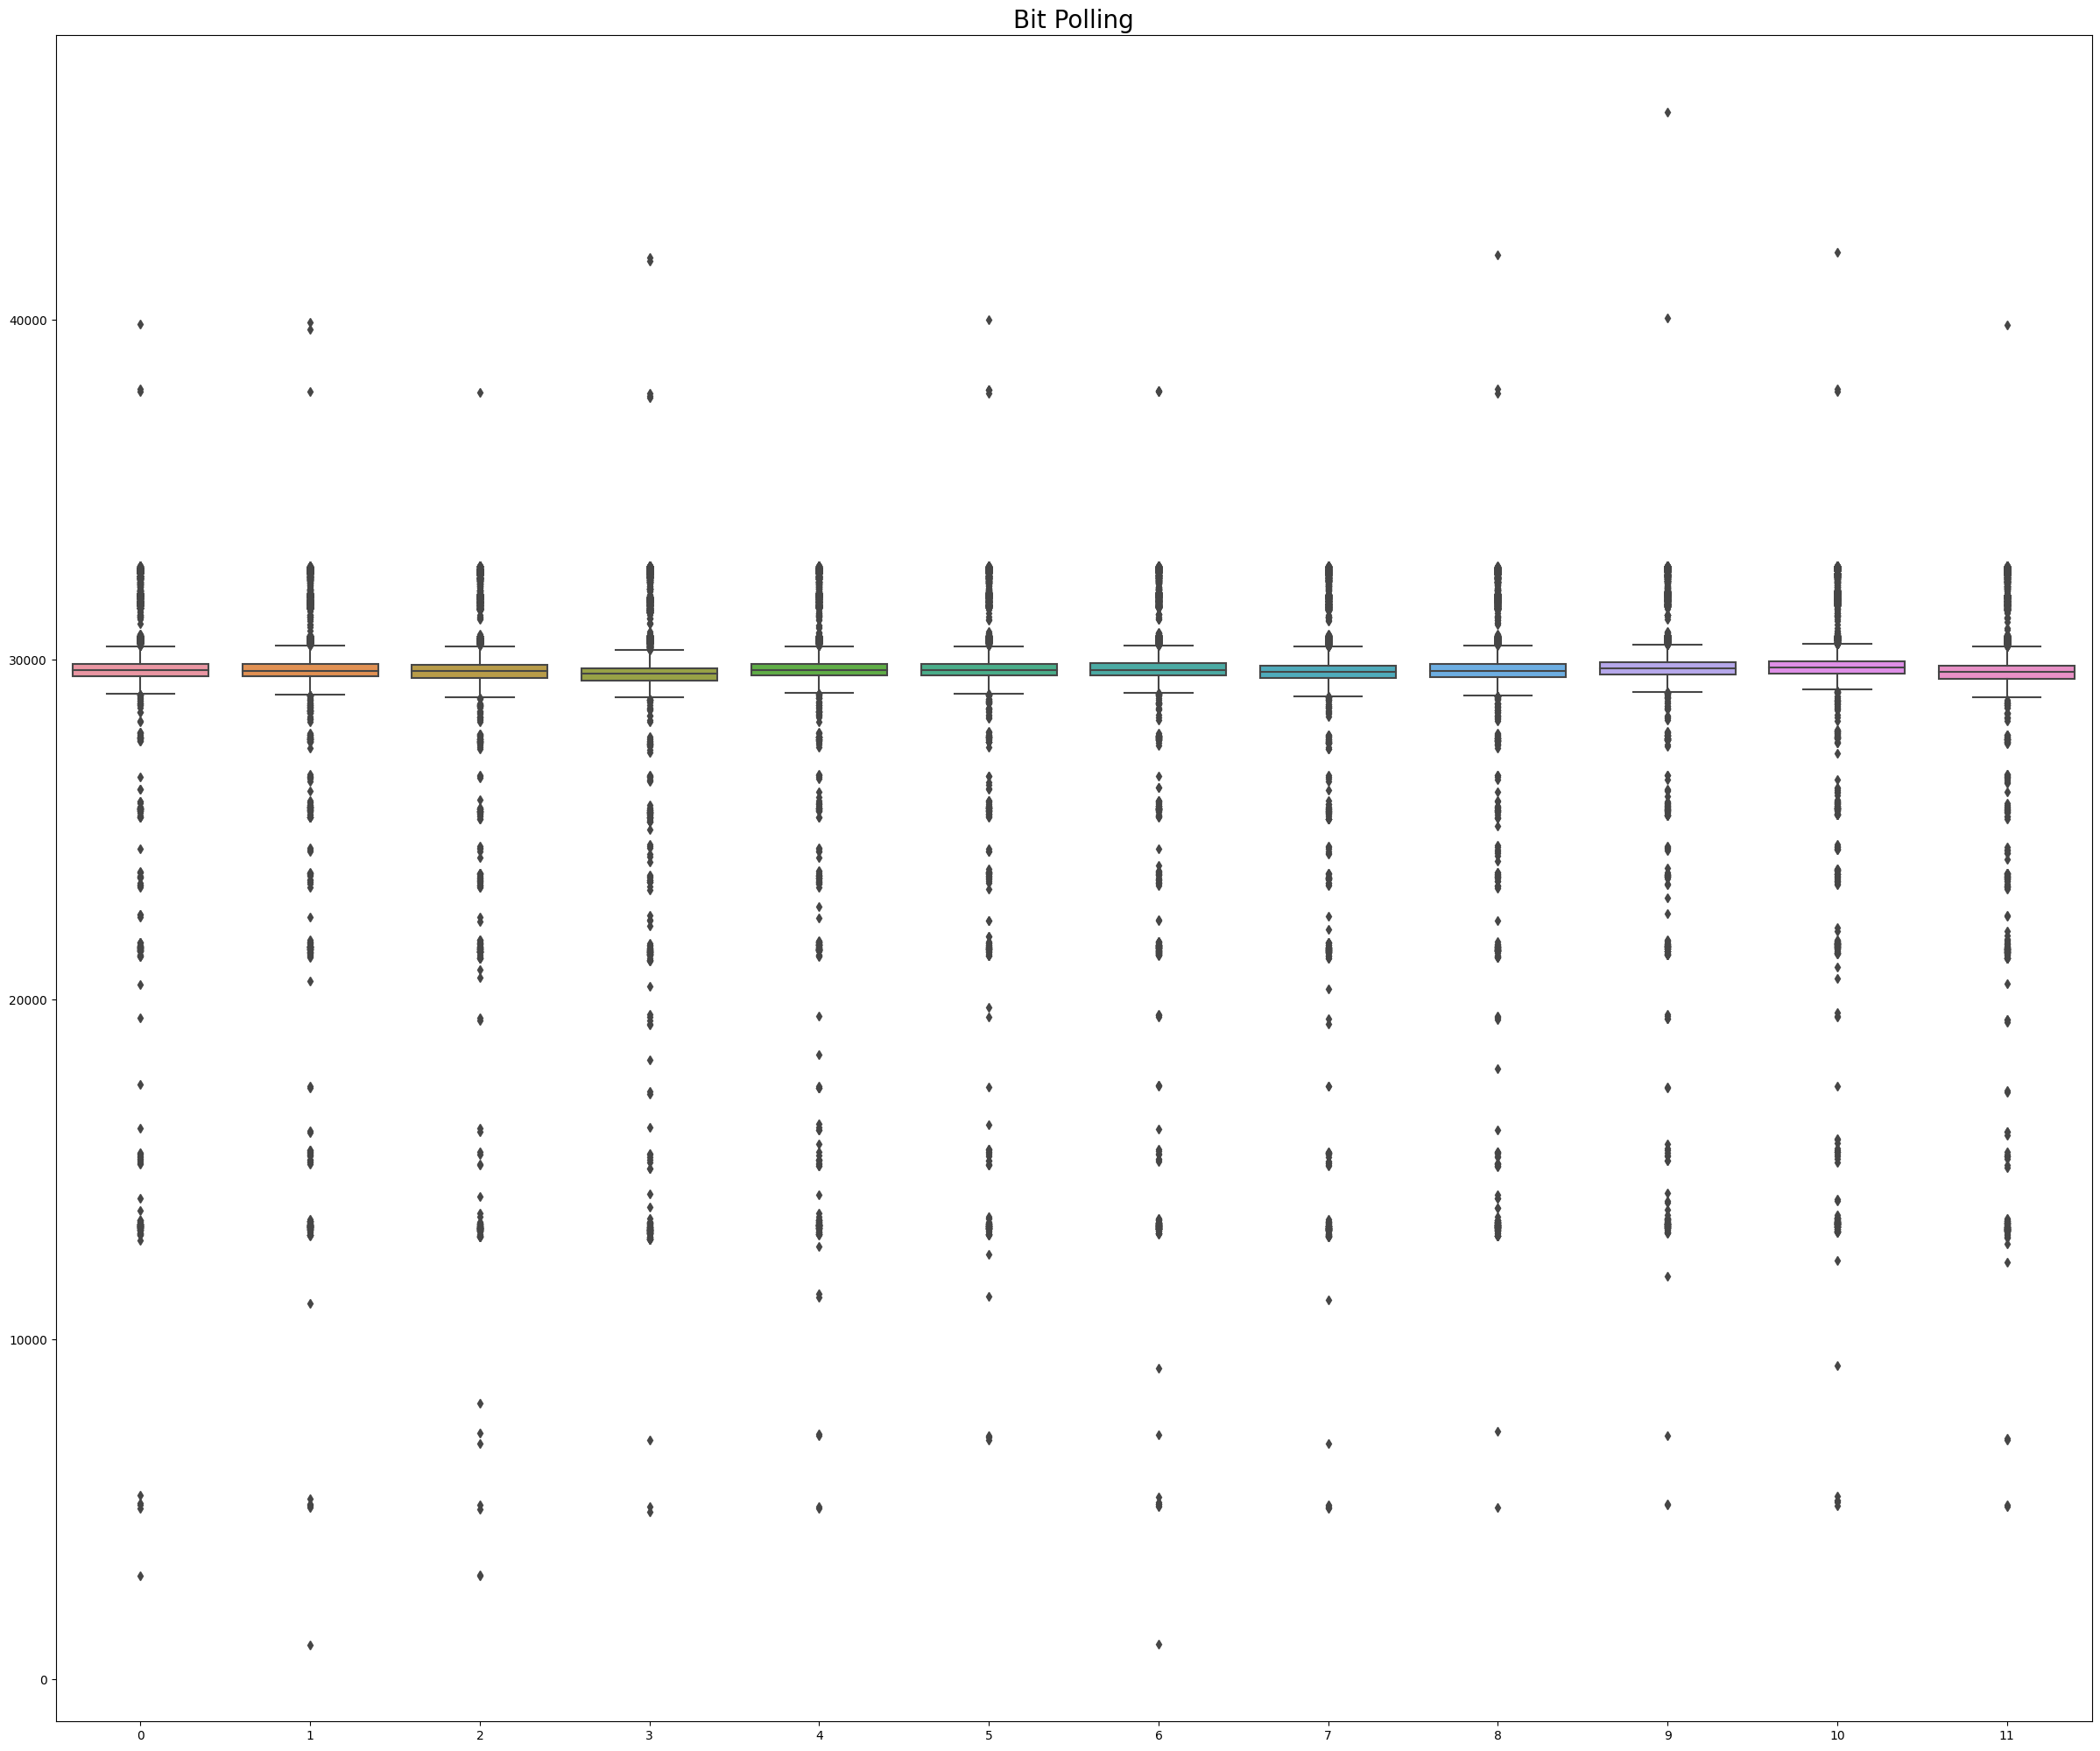

In [45]:
## Compare Mean Measure to Bit Polling
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
axs.set_title("Mean Measure", fontsize=20)
sns.violinplot(Xans)
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
axs.set_title("Bit Polling", fontsize=20)
sns.violinplot(Vans)

fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
axs.set_title("Mean Measure", fontsize=20)
sns.boxplot(Xans)
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
axs.set_title("Bit Polling", fontsize=20)
sns.boxplot(Vans)
